# КУРСОВОЙ ПРОЕКТ

# "МОДЕЛЬ КРЕДИТНОГО СКОРРИНГА"
### Слушатель факультета ИИ: Рудаков А.А.
Дата: март 2021

**Цель проекта:** предсказать факт невыполнения кредитных обязательств (Credit_default) в датасете test.csv.  

**Источник данных:** Два (2)  датасета с сайта соревнований Kaggle: [Credit Default](https://www.kaggle.com/c/gb-credit-default)
- train.csv (содержит признаки и факт невыполнения кредитных обязательств)
- test.csv (содержит только признаки).

## ОГЛАВЛЕНИЕ

#### [Путь к директориям и файлам](#path)
#### [Загрузка базовых библиотек](#lib)
#### [Оптимизация памяти](#memory)
#### [Загрузка основных скриптов](#scripts)
---

#### [1. Анализ файла train.csv](#1)
* **[Описание датасета train.csv](#data_desc)**
* **[Анализ данных исходного датасета](#data)**
* **Анализ целевой перемнной и ее признаков**
    * **[Категориальные признаки](#category)**
    * **[ВЫВОДЫ АНАЛИЗА КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ](#category_sum)**
    * **[Количественные признаки](#numeric)**
    * **[ВЫВОДЫ АНАЛИЗА КОЛИЧЕСТВЕННЫХ ПРИЗНАКОВ](#numeric_sum)**
    * **[Анализ целевой перемнной](#TARGET_NAME)**
* **[РЕЗУЛЬТАТЫ  АНАЛИЗА  ПРИЗНАКОВ ДЛЯ РАЗБИЕНИЯ И ОБУЧЕНИЯ](#conclusion)**
    
#### [2. Подготовка датасетов на базе train.csv](#2)

* **[Обработка дисбаланса классов целевой переменной train part of train](#disbalance_train)**
* **[Cохранение датасетов](#train_test_save)**
* **[Data Piple функция для обработки train_part of train.csv](#data_piple)**


**Путь к директориям и файлам**<a class='anchor' id='path'>

In [88]:
from pathlib import Path

DATA_ROOT = Path('.')
MODELS_PATH = Path('./models/')

# input
DATASET_PATH = DATA_ROOT / 'train.csv'
TEST_CSV_DATASET_PATH = DATA_ROOT / 'test.csv'

# output
TRAIN_FULL_PATH = DATA_ROOT / 'train_full.csv'
TRAIN_PART_PATH = DATA_ROOT / 'train_part.csv'
TEST_PART_PATH = DATA_ROOT / 'train_test_part.csv'
TRAIN_PART_BALANCED_PATH = DATA_ROOT / 'train_part_balanced.csv'

SCALER_FILE_PATH = MODELS_PATH / 'scaler.pkl'

**Загрузка базовых библиотек** <a class ='anchor' id = 'lib'> 

In [89]:
import warnings
warnings.filterwarnings('ignore')

In [90]:
import numpy as np
import pandas as pd

import pickle # сохранение модели

from matplotlib import pyplot as plt
from pylab import rcParams as rc
import seaborn as sns
from IPython.display import Image #Для визуализации внешних картинок в ноутбуке

from scipy.stats import mode,skew
from statistics import variance, median


# Загрузка моделей (библиотек) для обучения sci-kit learn (sklearn)

from sklearn.model_selection import train_test_split, KFold, GridSearchCV # Разделение датасета
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor

# Загрузка статистических методов и показателей из scipy

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

# Загрузка метрик оценки качества модели по условию курсового
from sklearn.metrics import mean_squared_error as mse, r2_score as r2, f1_score as f1
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix,
                             accuracy_score, classification_report, plot_confusion_matrix,
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)

#Активация отображения графиков matlib/mathlab 

%matplotlib inline 

# Для четкости отображения графиков и текста

%config InlineBackend.figure_format = 'svg'

**Оптимизация памяти под данные** <a class ='anchor' id ='memory'>

In [91]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

**Загрузка основных скриптов** <a class ='anchor' id = 'scripts'> 

In [92]:
# Функция устранения дисбаланса классов по целевой переменной

def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1)  

In [93]:
# Функция расчсета предсказанния целевой переменной на выбранной модели

def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [94]:
# Функция генерации отчета результата обучения и теста выбранной модели

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

## 1. Анализ файла train.csv<a class='anchor' id='1'>

**Описание датасета**<a class = 'anchor' id = 'data_desc'>
    
* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [95]:
df = pd.read_csv(DATASET_PATH)
df = reduce_mem_usage(df)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%


**Анализ данных исходного датасета<a class = 'anchor' id = 'data'>**

In [96]:
df.columns.to_list()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default']

In [97]:
df.describe()

Annual Income    Tax Liens  Number of Open Accounts  \
count   5.943000e+03  7500.000000              7500.000000   
mean    1.366390e+06     0.030133                11.130934   
std     8.453384e+05     0.271613                 4.908937   
min     1.645970e+05     0.000000                 2.000000   
25%     8.443410e+05     0.000000                 8.000000   
50%     1.168386e+06     0.000000                10.000000   
75%     1.640137e+06     0.000000                14.000000   
max     1.014934e+07     7.000000                43.000000   

       Years of Credit History  Maximum Open Credit  \
count              7500.000000         7.500000e+03   
mean                 18.317446         9.451526e+05   
std                   7.041938         1.602614e+07   
min                   4.000000         0.000000e+00   
25%                  13.500000         2.792295e+05   
50%                  17.000000         4.781590e+05   
75%                  21.799999         7.935015e+05   
max                  57.700001         1.304726e+09   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                  7500.0000                   3419.000000   7486.000000   
mean                      0.1700                     34.692600      0.117152   
std                       0.4986                     21.688801      0.347197   
min                       0.0000                      0.000000      0.000000   
25%                       0.0000                     16.000000      0.000000   
50%                       0.0000                     32.000000      0.000000   
75%                       0.0000                     50.000000      0.000000   
max                       7.0000                    118.000000      4.000000   

       Current Loan Amount  Current Credit Balance   Monthly Debt  \
count               7500.0            7.500000e+03    7500.000000   
mean            11873135.0            2.898332e+05   18314.453125   
std             31926302.0            3.178713e+05   11926.758789   
min                11242.0            0.000000e+00       0.000000   
25%               180169.0            1.142565e+05   10067.500000   
50%               309573.0            2.093230e+05   16076.500000   
75%               519882.0            3.604062e+05   23818.000000   
max            100000000.0            6.506797e+06  136679.000000   

       Credit Score  Credit Default  
count   5943.000000     7500.000000  
mean    1151.087524        0.281733  
std     1604.447510        0.449874  
min      585.000000        0.000000  
25%      711.000000        0.000000  
50%      731.000000        0.000000  
75%      743.000000        1.000000  
max     7510.000000        1.000000

In [98]:
TARGET = df['Credit Default'] # целевая переменная
TARGET.describe()

count    7500.000000
mean        0.281733
std         0.449874
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Credit Default, dtype: float64

In [99]:
TARGET.size

7500

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

In [101]:
df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [102]:
TARGET_NAME = ['Credit Default']
BASE_FEATURES_NAME = df.drop(TARGET_NAME, axis = 1).columns.tolist()
CATEGORY_FEATURES_NAME = df.select_dtypes(include=['category']).columns.tolist()
NUMERIC_FEATURES_NAME = df.select_dtypes(include=['float16', 'float32', 'float64']).columns.tolist()
FEATURES_NA_NAME = ['Annual Income', 'Years in current job','Months since last delinquent','Bankruptcies','Credit Score']

In [103]:
df[TARGET_NAME].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Credit Default  7500 non-null   int8 
dtypes: int8(1)
memory usage: 7.4 KB


In [104]:
for j in [TARGET_NAME,CATEGORY_FEATURES_NAME,NUMERIC_FEATURES_NAME]:
    print('{}\n {}\n'.format('*'*50,str(j)))
    df[j].info()

**************************************************
 ['Credit Default']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Credit Default  7500 non-null   int8 
dtypes: int8(1)
memory usage: 7.4 KB
**************************************************
 ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Home Ownership        7500 non-null   category
 1   Years in current job  7129 non-null   category
 2   Purpose               7500 non-null   category
 3   Term                  7500 non-null   category
dtypes: category(4)
memory usage: 30.8 KB
**************************************************
 ['Annual Income', 'Tax Liens'

In [105]:
df[FEATURES_NA_NAME].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Annual Income                 5943 non-null   float32 
 1   Years in current job          7129 non-null   category
 2   Months since last delinquent  3419 non-null   float32 
 3   Bankruptcies                  7486 non-null   float32 
 4   Credit Score                  5943 non-null   float32 
dtypes: category(1), float32(4)
memory usage: 125.0 KB


К заполнению пропущенных данных подлежат признаки :
* **float32** :
    * **Annual Income** (годовой доход) 5943/7500
    * **Months since last delinquent** (количество месяцев с последней просрочки платежа)  3419 /7500
    * **Credit Score** (баллы кредитного рейтинга) 5943 /7500
  
* **category** :
    * **Years in current job** (количество лет на текущем месте работы) 7129 /7500

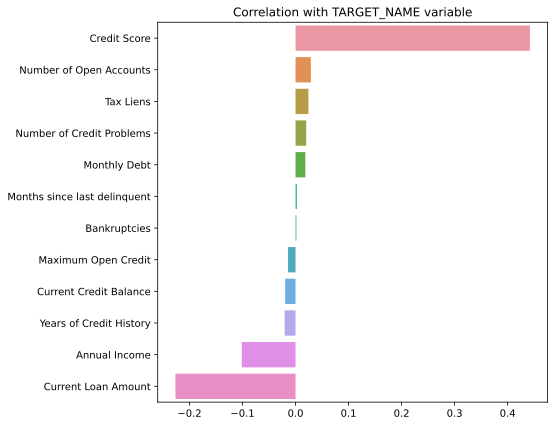

In [106]:
corr_with_TARGET_NAME = df[BASE_FEATURES_NAME + TARGET_NAME].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(7, 7))

sns.barplot(x=corr_with_TARGET_NAME.values, y=corr_with_TARGET_NAME.index)

plt.title('Correlation with TARGET_NAME variable')
plt.show()

Наиболее влияющие признаки на целевую переменную с точки зрения линейной зависимости:
1. Положительная корреляция >0.2 у признаков **Credit Score**
2. Отрицаиельная корреляция > |0.2| у признак  **Current Loan Amount**
3. Отрицаиельная слабая корреляция у признака **Annual Income**

In [107]:
df[['Credit Score', 'Current Loan Amount', 'Annual Income']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Credit Score         5943 non-null   float32
 1   Current Loan Amount  7500 non-null   float32
 2   Annual Income        5943 non-null   float32
dtypes: float32(3)
memory usage: 88.0 KB


In [108]:
# функция создания данных наблюдений на основе выбранного признака и наблюдений целевой переменной. 
           
def cat_target_transform(df):
        
    target_name = ['Credit Default']
    category_names = df.select_dtypes(include=['category']).columns.tolist()
    dummy = pd.get_dummies(df[category_names],prefix = category_names, drop_first = True)
    df_new = pd.concat([dummy,df[target_name]], axis = 1)
    
    return df_new

In [109]:
def shapir_check(df, feature_name_list): # Проверка на нормальность количественных переменных
    
    target_name = 'Credit Default'
    
    for i in feature_name_list:
        stat, p = shapiro(df[i]) # тест Шапиро-Уилка
        alpha = 0.05
        print(f'Признак: {str(i)}\n\tStatistics = {round(stat,3)}\n\tp-value = {round(p,4)}')
              
        if p > alpha:
            print(f'-----> Принять гипотезу о нормальности\n{"*"*70}')
        else:
            print(f'-----> Отклонить гипотезу о нормальности\n{"*"*70}')

In [110]:
shapir_check(df,NUMERIC_FEATURES_NAME)

Признак: Annual Income
	Statistics = nan
	p-value = 1.0
-----> Принять гипотезу о нормальности
**********************************************************************
Признак: Tax Liens
	Statistics = 0.088
	p-value = 0.0
-----> Отклонить гипотезу о нормальности
**********************************************************************
Признак: Number of Open Accounts
	Statistics = 0.937
	p-value = 0.0
-----> Отклонить гипотезу о нормальности
**********************************************************************
Признак: Years of Credit History
	Statistics = 0.943
	p-value = 0.0
-----> Отклонить гипотезу о нормальности
**********************************************************************
Признак: Maximum Open Credit
	Statistics = 0.01
	p-value = 0.0
-----> Отклонить гипотезу о нормальности
**********************************************************************
Признак: Number of Credit Problems
	Statistics = 0.375
	p-value = 0.0
-----> Отклонить гипотезу о нормальности
**********************

По критерию Шапиро-Уилка **нормальное распределние** предположительно имеют следующие числовые признаки:
1. Annual Income
2. Months since last delinquent
3. Bankruptcies
4. Credit Score

Остальные числовые признаки (количественные) **не поподают под нормальное распределение**:
1. Tax Liens
2. Number of Open Accounts
3. Years of Credit History
4. Maximum Open Credit
5. Number of Credit Problems
6. Current Loan Amount
7. Current Credit Balance
8. Monthly Debt

In [111]:
shapir_check(df,TARGET_NAME)

Признак: Credit Default
	Statistics = 0.563
	p-value = 0.0
-----> Отклонить гипотезу о нормальности
**********************************************************************


Целевая переменная **Credit Default**, являющая категориальной, отклоняется от нормального распределения.

### Категориальные признаки<a class = 'anchor' id = 'category'>

In [112]:
df[CATEGORY_FEATURES_NAME].head(10)

Home Ownership Years in current job             Purpose        Term
0       Own Home                  NaN  debt consolidation  Short Term
1       Own Home            10+ years  debt consolidation   Long Term
2  Home Mortgage              8 years  debt consolidation  Short Term
3       Own Home              6 years  debt consolidation  Short Term
4           Rent              8 years  debt consolidation  Short Term
5           Rent              7 years               other   Long Term
6  Home Mortgage            10+ years   home improvements  Short Term
7           Rent            10+ years               other  Short Term
8  Home Mortgage              5 years   home improvements  Short Term
9  Home Mortgage               1 year  debt consolidation   Long Term

In [113]:
df[CATEGORY_FEATURES_NAME].nunique()

Home Ownership           4
Years in current job    11
Purpose                 15
Term                     2
dtype: int64

In [114]:
for i in CATEGORY_FEATURES_NAME:
    print('CATEGORY FEATURE NAME---->\t' + str(i) + '\n\n' + str(df[i].value_counts()) + '\n' + str('*'*100) + '\n')

CATEGORY FEATURE NAME---->	Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

CATEGORY FEATURE NAME---->	Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

CATEGORY FEATURE NAME---->	Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding         

In [115]:
df[CATEGORY_FEATURES_NAME].describe()

Home Ownership Years in current job             Purpose        Term
count            7500                 7129                7500        7500
unique              4                   11                  15           2
top     Home Mortgage            10+ years  debt consolidation  Short Term
freq             3637                 2332                5944        5556

Рассмотрим каждый категориальный признак в разрезе целевой перемнной, так и в разрезе категорий, для понимания важности признака или сокращения признаков, при переводе их в dummy.

In [116]:
print('len is : '+ str(len(CATEGORY_FEATURES_NAME)))
CATEGORY_FEATURES_NAME

len is : 4


['Home Ownership', 'Years in current job', 'Purpose', 'Term']

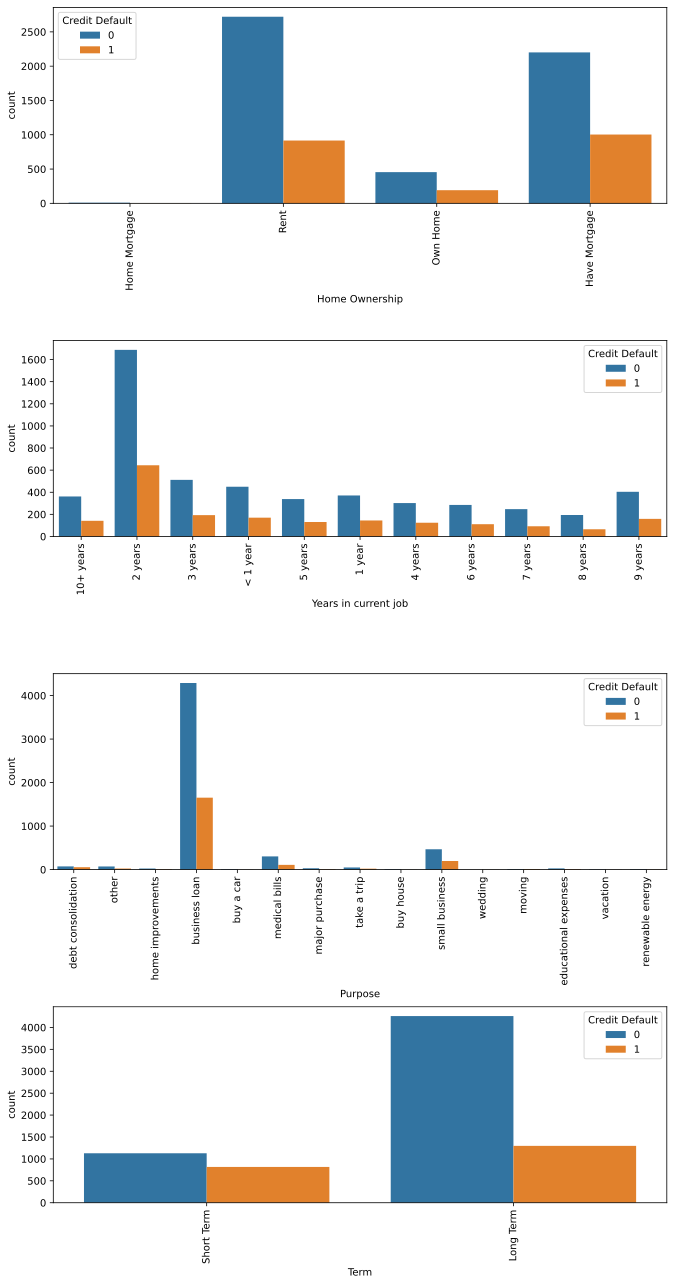

In [117]:
fig, axes = plt.subplots(nrows= 4, ncols=1, figsize=(11, 22))

ax1, ax2, ax3, ax4 = axes.flatten()


ax1 = plt.subplot(411)
ax2 = plt.subplot(412)
ax3 = plt.subplot(413)
ax4 = plt.subplot(414)

sns.countplot(x=CATEGORY_FEATURES_NAME[0], hue=TARGET_NAME[0], data = df, ax = ax1).set_xticklabels(
    labels = df[CATEGORY_FEATURES_NAME[0]].value_counts().index.to_list(),rotation=90)

sns.countplot(x=CATEGORY_FEATURES_NAME[1], hue=TARGET_NAME[0], data = df, ax = ax2).set_xticklabels(
    labels = df[CATEGORY_FEATURES_NAME[1]].value_counts().index.to_list(),rotation=90)

sns.countplot(x=CATEGORY_FEATURES_NAME[2], hue=TARGET_NAME[0],  data = df, ax = ax3).set_xticklabels(
    labels = df[CATEGORY_FEATURES_NAME[2]].value_counts().index.to_list(),rotation=90)

sns.countplot(x=CATEGORY_FEATURES_NAME[3], hue=TARGET_NAME[0], data = df, ax = ax4).set_xticklabels(
    labels = df[CATEGORY_FEATURES_NAME[3]].value_counts().index.to_list(),rotation=90)

plt.subplots_adjust(wspace=0, hspace=0.7)

1. **Home Ownership** имеет категории, которые достаточно близки по значениям целевой переменной и можно обьъеденить в одну группу:
    * **Group1** - включает **Rent, Have Mortgage**
    * **Group2** - включает **Own Home**
    * **Group3** - включает **Home Mortgage** но практически не влияет на целевую перемнную и ***можно выкинуть при необходимости***,предварительно проанализировав распределения и отклонения средних в выборках.
2. **Years in current job** имеет несколько категорий, которые дают более или менее одинаковые значения целевой перемнной и могут быть объеденены в одну:
    * **Group1** - включает **1 year, 4 years, 5 years, 6 years, 7 years, 8 years**
    * **Group2** - включает **2 years**
    * **Group3** - включает **< 1 year,3 years**
    * **Group4** - включает **9 years,10+ years**
3. **Purpose** имеет несколько категорий, которые дают более или менее одинаковые значения целевой перемнной и могут быть объеденены в одну:
    * **Group1** - включает **business loan**
    * **Group2** - включает **small business**
    * **Group3** - включает **medical bills**
    * **Group4** - включает **other,debt consolidation, take a trip**
    * **Group5** - включает **home improvements,buy a car, major purchase,buy house, wedding, moving, educational expenses, vacation, renewable energy**, которые можно выкинуть или объеденить в одну, предварительно проанализировав распределения, отклонения средних в выборках.
4. **Term** остается без изменений и будет содержать две категории ***"Short term"*** и ***"Long term"***, как **бинарные признаки**.

Проведем анализ статистических параметров рассматриваемых признаков, перед решением о том, оставить их или нет.
Предварительо введем функцию расчета  хи квадрат значимости нулевой гипотезы для категориальных переменных, в разрезе целевой перемнной.

In [118]:
# Функция проверки гипотезы по Хи квадрат

def chi_valid(df,category_feature_name, group):
    
    df['Id'] = df.index
    target = 'Credit Default'
       
    feat_with_target = df.loc[df[category_feature_name].isin(group),
                               ['Id', category_feature_name, target]]
    
    table = feat_with_target.pivot_table(values='Id', 
                                      index = category_feature_name,
                                      columns= target, aggfunc='count')
   
    alpha = 0.05
    chi2, p, _, _ = chi2_contingency(table)
    
    if p > alpha:
        print(f'p - value: {p}\nГипотезу H0 отбросить нельзя - ОБЪЕДЕНИТЬ В ГРУППУ {group}')
    else:
        print(f'p - value: {p}\nГипотезу H0 можно отклонить - НЕЛЬЗЯ ОБЪЕДЕНИТЬ В ГРУППУ')
          
    return table
        

### Home Ownership

Изучив получившийся график, видно, что Rent, Have Mortgage имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет, например, объединить их в одну категорию.

**Гипотеза** 

* ***Нулевая гипотеза H0***: ожидаемые и наблюдаемые частоты согласованы
* ***Альтернативная гипотеза H1***: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* ***Критерий:*** Хи-квадрат Пирсона
* ***Уровень значимости** $\normalsize \alpha$: 0.05

Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий Rent и Have Mortgage признака Home Ownership в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

In [119]:
CATEGORY_FEATURES_NAME

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [120]:
group1 = ['Rent', 'Have Mortgage']
group2 = ['Own Home']
group3 = ['Home Mortgage']

In [121]:
chi_valid(df,CATEGORY_FEATURES_NAME[0],group1)

p - value: 0.43541710122920296
Гипотезу H0 отбросить нельзя - ОБЪЕДЕНИТЬ В ГРУППУ ['Rent', 'Have Mortgage']


Credit Default     0     1
Home Ownership            
Have Mortgage     10     2
Rent            2201  1003

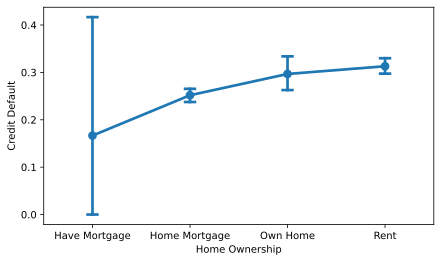

In [189]:
plt.figure(figsize=(7, 4))

sns.pointplot(x= CATEGORY_FEATURES_NAME[0], y=TARGET_NAME[0], data=df, capsize=.1,);

P-value получилось больше выбранного уровня значимости (P-value = 0.43 > 0.05), соответственно у нас нет оснований для отвержения нулевой гипотезы H0 и можно допустить, что ***категории Rent и Have Mortage одинаково влияют на целевую переменную и их можно объединить в одну категорию***.

Проверим, правильно ли мы выделили остальные группы по одной категории в каждой.
Проведем расчет для H0 и H1, но для новой созданной пары категорий group_test (**Own Home** и **Home Mortgage**), где **Home Mortgage** предполагалась к выбросу,как имеющая практически нулевую долю в целевой переменной.

In [122]:
group_test = group2 + group3
chi_valid(df,CATEGORY_FEATURES_NAME[0],group_test)

p - value: 0.018554563643657606
Гипотезу H0 можно отклонить - НЕЛЬЗЯ ОБЪЕДЕНИТЬ В ГРУППУ


Credit Default     0    1
Home Ownership           
Home Mortgage   2721  916
Own Home         455  192

P-value получилось меньше выбранного уровня значимости (P-value = 0.018 < 0.05), соответственно нулевая гипотеза H0 отвергается, и можно допустить, что ***категории Own Home и Home Mortgage не влияют в равной степени на целевую переменную и их нельзя объединить в одну категорию***.

### Years in current job

Изучив получившийся график, видно, что  имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет, например, объединить их в одну категорию.

**Гипотеза** 

* ***Нулевая гипотеза H0***: ожидаемые и наблюдаемые частоты в выбранной группе категорий согласованы
* ***Альтернативная гипотеза H1***: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* ***Критерий:*** Хи-квадрат Пирсона
* ***Уровень значимости** $\normalsize \alpha$: 0.05

Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий ранее выбранныых групп признака Years in current job в выбранный критерий по очереди, после чего оценить значение достигаемого уровня значимости p-value и сравнить его с выбранным порогом альфа. Если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

<AxesSubplot:xlabel='Years in current job', ylabel='Credit Default'>

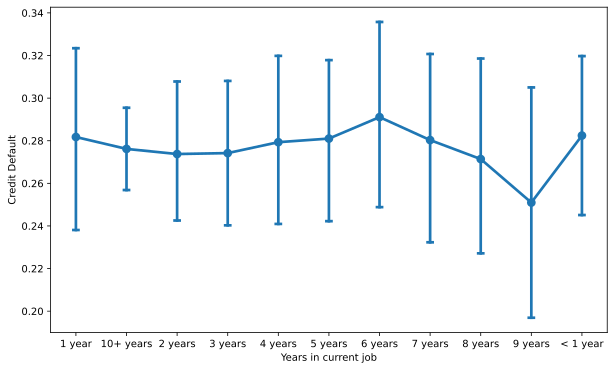

In [195]:
plt.figure(figsize=(10, 6))

sns.pointplot(x= CATEGORY_FEATURES_NAME[1], y=TARGET_NAME[0], data=df, capsize=.1)

Начнем с первой группы, ранее выделенной:
* **Group1:** включает следующие категори признака  **1 year, 4 years, 5 years, 6 years, 7 years, 8 years**.


In [123]:
group1 = ['1 year','4 years', '5 years','6 years','7 years', '8 years']
chi_valid(df,CATEGORY_FEATURES_NAME[1],group1)

p - value: 0.9959171451670101
Гипотезу H0 отбросить нельзя - ОБЪЕДЕНИТЬ В ГРУППУ ['1 year', '4 years', '5 years', '6 years', '7 years', '8 years']


Credit Default          0    1
Years in current job          
1 year                362  142
4 years               338  131
5 years               371  145
6 years               302  124
7 years               285  111
8 years               247   92

P-value получилось больше выбранного уровня значимости (P-value = 0.995 > 0.05), соответственно у нас нет оснований для отвержения нулевой гипотезы H0 и можно допустить, что для категориального признака можно объеденить в одну группу категории ***1 year, 4 years, 5 years, 6 years, 7 years, 8 years*** одинаково влияющих на целевую переменную.

Аналогично проведем расчет для H0 и H1 для оставшихся групп:
* **Group2** включает ***2 years***. 
    * *Для данной группы расчета не будет,т.к она оказывает существуенное влияние на целевую переменную и не имеет частот в других катекгориях,которые бы согласовывались бы с ней.*
* **Group3** включает **< 1 year,3 years**
* **Group4** включает ***9 years,10+ years***

In [124]:
group2 = ['2 years']
group3 = ['< 1 year','3 years']
group4 = ['9 years','10+ years']

In [125]:
chi_valid(df,CATEGORY_FEATURES_NAME[1],group3)

p - value: 0.8023983014982438
Гипотезу H0 отбросить нельзя - ОБЪЕДЕНИТЬ В ГРУППУ ['< 1 year', '3 years']


Credit Default          0    1
Years in current job          
3 years               450  170
< 1 year              404  159

P-value получилось меньше выбранного уровня значимости (P-value = 0.802 < 0.05), соответственно нулевая гипотеза H0 отвергается,  что для категориального признака можно объеденить в одну группу категории ***< 1 year,3 years*** одинаково влияющих на целевую переменную.

In [126]:
chi_valid(df,CATEGORY_FEATURES_NAME[1],group4)

p - value: 0.4299373704294749
Гипотезу H0 отбросить нельзя - ОБЪЕДЕНИТЬ В ГРУППУ ['9 years', '10+ years']


Credit Default           0    1
Years in current job           
10+ years             1688  644
9 years                194   65

P-value получилось меньше выбранного уровня значимости (P-value = 0.43 < 0.05), соответственно нулевая гипотеза H0 отвергается,  что для категориального признака можно объеденить в одну группу категории ***< 9 years,10+ years*** одинаково влияющих на целевую переменную. Исходя из наменее низкого уровня значимости дял последней группы, попробуем добавить в объедениение :

* **Group5_3** включает group3 = '< 1 year', '3 years'  и '9 years'
* **Group6_1** включает group1 = 1 year, 4 years, 5 years, 6 years, 7 years, 8 years и 10+ years

In [127]:
group5_3 = group1 + ['9 years']
group6_1 = group1 + ['10+ years']

chi_valid(df,CATEGORY_FEATURES_NAME[1],group5_3)

p - value: 0.9628235107486994
Гипотезу H0 отбросить нельзя - ОБЪЕДЕНИТЬ В ГРУППУ ['1 year', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years']


Credit Default          0    1
Years in current job          
1 year                362  142
4 years               338  131
5 years               371  145
6 years               302  124
7 years               285  111
8 years               247   92
9 years               194   65

In [128]:
chi_valid(df,CATEGORY_FEATURES_NAME[1],group6_1)

p - value: 0.997420996559249
Гипотезу H0 отбросить нельзя - ОБЪЕДЕНИТЬ В ГРУППУ ['1 year', '4 years', '5 years', '6 years', '7 years', '8 years', '10+ years']


Credit Default           0    1
Years in current job           
1 year                 362  142
10+ years             1688  644
4 years                338  131
5 years                371  145
6 years                302  124
7 years                285  111
8 years                247   92

Получается, что для категориального признака **Years in current job** из 11 категорий, для моделирования останутся 4 новых категории, представляющих собой объедение изначальных по прицнипу ниже:

* **Group1** - включает 1 year, 4 years, 5 years, 6 years, 7 years, 8 years, 10+ years (***p = 0.9974 < 0 .05***)
* **Group2** - включает 2 years
* **Group3** - включает < 1 year,3 years (***p = 0.803 < 0 .05***)
* **Group4** - включает 9 years

### Purpose

Изучив получившийся график, видно, что  имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет, например, объединить их в одну категорию.

**Гипотеза** 

* ***Нулевая гипотеза H0***: ожидаемые и наблюдаемые частоты в выбранной группе категорий согласованы
* ***Альтернативная гипотеза H1***: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* ***Критерий:*** Хи-квадрат Пирсона
* ***Уровень значимости** $\normalsize \alpha$: 0.05

Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий ранее выбранныых групп признака Purpose в выбранный критерий по очереди, после чего оценить значение достигаемого уровня значимости p-value и сравнить его с выбранным порогом альфа. Если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

<AxesSubplot:xlabel='Credit Default', ylabel='Purpose'>

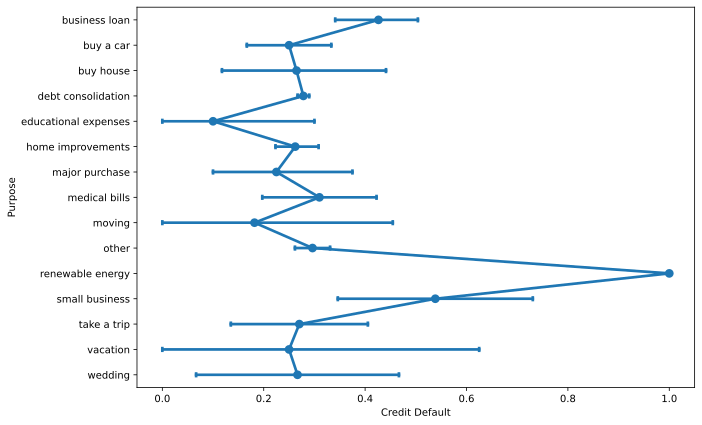

In [202]:
plt.figure(figsize=(10, 7))

sns.pointplot(y= CATEGORY_FEATURES_NAME[2], x=TARGET_NAME[0], data=df, capsize=.1)

**Рассматриваемые группы:**
1. **Group1** - включает business loan
2. **Group2** - включает small business
3. **Group3** - включает medical bills
4. **Group4** - включает other,debt consolidation, take a trip
5. **Group5** - включает home improvements,buy a car, major purchase,buy house, wedding, moving, educational expenses, vacation, renewable energy, которые можно выкинуть или объеденить в одну, предварительно проанализировав распределения, отклонения средних в выборках.  

In [129]:
group1 = ['business loan']
group2 = ['small business']
group3 = ['medical bills']
group4 = ['other','debt consolidation', 'take a trip']
group5 = ['home improvements','buy a car', 'major purchase','buy house', 'wedding',
          'moving', 'educational expenses', 'vacation', 'renewable energy']

In [130]:
CATEGORY_FEATURES_NAME

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [131]:
chi_valid(df,CATEGORY_FEATURES_NAME[2],group4)

p - value: 0.6137808531614353
Гипотезу H0 отбросить нельзя - ОБЪЕДЕНИТЬ В ГРУППУ ['other', 'debt consolidation', 'take a trip']


Credit Default         0     1
Purpose                       
debt consolidation  4290  1654
other                468   197
take a trip           27    10

P-value получилось больше выбранного уровня значимости (P-value = 0.613 > 0.05), соответственно у нас нет оснований для отвержения нулевой гипотезы H0 и можно допустить, что для категориального признака можно объеденить в одну группу категории ***other,debt consolidation, take a trip*** одинаково влияющих на целевую переменную.

Аналогично проведем расчет для H0 и H1 для оставшейся группы:
* **Group5** включает home improvements,buy a car, major purchase,buy house, wedding, moving, educational expenses, vacation, renewable energy, которые можно выкинуть или объеденить в одну, предварительно проанализировав распределения, отклонения средних в выборках.

In [132]:
chi_valid(df,CATEGORY_FEATURES_NAME[2],group5)

p - value: nan
Гипотезу H0 можно отклонить - НЕЛЬЗЯ ОБЪЕДЕНИТЬ В ГРУППУ


Credit Default            0      1
Purpose                           
buy a car              72.0   24.0
buy house              25.0    9.0
educational expenses    9.0    1.0
home improvements     304.0  108.0
major purchase         31.0    9.0
moving                  9.0    2.0
renewable energy        NaN    2.0
vacation                6.0    2.0
wedding                11.0    4.0

In [133]:
df[CATEGORY_FEATURES_NAME[2]].isna().sum()

0

Как видно категория renewable energy ни разу не встретилась при рассмотрении ее влияния на целевую перемнную в разрезе значения 0 - кредит погашен вовремя. Вынесем пока категорию в отдельную группу №6

In [134]:
group5 = ['home improvements','buy a car', 'major purchase','buy house', 'wedding',
          'moving', 'educational expenses', 'vacation']
group6 = ['renewable energy']

In [135]:
chi_valid(df,CATEGORY_FEATURES_NAME[2],group5)

p - value: 0.9642589680639521
Гипотезу H0 отбросить нельзя - ОБЪЕДЕНИТЬ В ГРУППУ ['home improvements', 'buy a car', 'major purchase', 'buy house', 'wedding', 'moving', 'educational expenses', 'vacation']


Credit Default          0    1
Purpose                       
buy a car              72   24
buy house              25    9
educational expenses    9    1
home improvements     304  108
major purchase         31    9
moving                  9    2
vacation                6    2
wedding                11    4

In [136]:
group_test = group1 + group2
chi_valid(df,CATEGORY_FEATURES_NAME[2],group_test)

p - value: 0.40483403834216214
Гипотезу H0 отбросить нельзя - ОБЪЕДЕНИТЬ В ГРУППУ ['business loan', 'small business']


Credit Default   0   1
Purpose               
business loan   74  55
small business  12  14

Получается, что для категориального признака **Purpose** из 15 категорий, для моделирования останутся 5 новых категории, представляющих собой объедение изначальных по прицнипу ниже:

* **Group1** - включает business loan, small business (***p = 0.404 > 0.05***)
* **Group2** - включает medical bills'
* **Group3** - включает 'other','debt consolidation', 'take a trip' (***p = 0.614 > 0 .05***)
* **Group4** - включает home improvements, buy a car, major purchase,buy house, wedding, moving, educational expenses,vacation
* **Group5** - включает renewable energy

### Term

**Гипотеза** 

* ***Нулевая гипотеза H0***: ожидаемые и наблюдаемые частоты в выбранной группе категорий согласованы
* ***Альтернативная гипотеза H1***: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* ***Критерий:*** Хи-квадрат Пирсона
* ***Уровень значимости** $\normalsize \alpha$: 0.05

Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий ранее выбранныых групп признака Term в выбранный критерий по очереди, после чего оценить значение достигаемого уровня значимости p-value и сравнить его с выбранным порогом альфа. Если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

**Рассматриваемые группы:**
Попробуем объеденитьт две категории признака и посмотерть,можно ли оставитить одну категорию или придется переводить признак в бинарный, где 0 - short trem, а 1 - long term

<AxesSubplot:xlabel='Term', ylabel='Credit Default'>

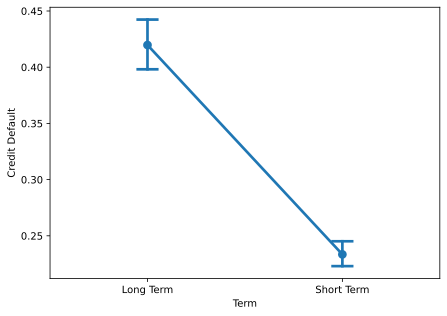

In [204]:
plt.figure(figsize=(7, 5))

sns.pointplot(x= CATEGORY_FEATURES_NAME[3], y=TARGET_NAME[0], data=df, capsize=.1)

In [137]:
group1 = ['Short Term', 'Long Term']

In [138]:
CATEGORY_FEATURES_NAME

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [139]:
chi_valid(df,CATEGORY_FEATURES_NAME[3],group1)

p - value: 1.82798593305453e-55
Гипотезу H0 можно отклонить - НЕЛЬЗЯ ОБЪЕДЕНИТЬ В ГРУППУ


Credit Default     0     1
Term                      
Long Term       1128   816
Short Term      4259  1297

P-value получилось больше выбранного уровня значимости (P-value = 0.0000... < 0.05), соответственно у нас нет оснований для  принятия нулевой гипотезы H0. Будем переводить данный признак в бианрный,как и планировали. 

### ВЫВОДЫ АНАЛИЗА КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ <a class ='anchor' id ='category_sum'>

---
**ОБРАБОТКА ПРОПУСКОВ КАТЕГОРИАЛЬНЫМ ПРИЗНАКАМ:**
1. **Years in current job**  заполнено данными 7129 /7500


**ОБЪЕДЕНЕНИЯ КАТЕГОРИЙ ПРОИЗНАКОВ В НОВЫЕ ГРУППЫ/КАТЕГОРИИ (Хи-квадрат)**

1. **Home Ownership** - признак разбиваем на три (3) категории/группы существующих 4-х категорий признака:
    * **Group1** - включает **Rent , Have Mortage**
    * **Group2** - включает **Own Home**
    * **Group3**-  включает **Home Mortgage**
        * *Сократили категории признака до 3-х (**на 1 меньше, чем было**)*
---

2. **Years in current job** - признак разбиваем на четыре (4) категории/группы существующих 11-и категорий признака:
    * **Group1** - включает **1 year, 4 years, 5 years, 6 years, 7 years, 8 years, 10+ years**
    * **Group2** - включает **2 years**
    * **Group3**-  включает **< 1 year,3 years**
    * **Group4**-  включает **9 years**
        * *Сократили категории признака до 4-х (**на 7 меньше, чем было**)*
    ---
3. **Purpose** - признак разбиваем на пять (5) категорий/групп существующих 15-и категорий признака:
    * **Group1** - включает **business loan, small business**
    * **Group2** - включает **medical bills**
    * **Group3**-  включает **other','debt consolidation', 'take a trip**
    * **Group4**-  включает **home improvements, buy a car, major purchase,buy house, wedding, moving, educational expenses,vacation**
    * **Group5**-  включает **renewable energy**
        * *Сократили категории признака до 5-и (**на 10 меньше, чем было**)*
    ---
4. **Term** - признак переводим в бинарный формат:
    * **0** - для значения **Short Term**
    * **1** - для значения **Long Term**
    ---
    

### Количественные признаки <a class = 'anchor' id = 'numeric'>

In [140]:
NUMERIC_FEATURES_NAME

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Tax Liens'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>],
       [<AxesSubplot:title={'center':'Years of Credit History'}>,
        <AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Number of Credit Problems'}>],
       [<AxesSubplot:title={'center':'Months since last delinquent'}>,
        <AxesSubplot:title={'center':'Bankruptcies'}>,
        <AxesSubplot:title={'center':'Current Loan Amount'}>],
       [<AxesSubplot:title={'center':'Current Credit Balance'}>,
        <AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>]], dtype=object)

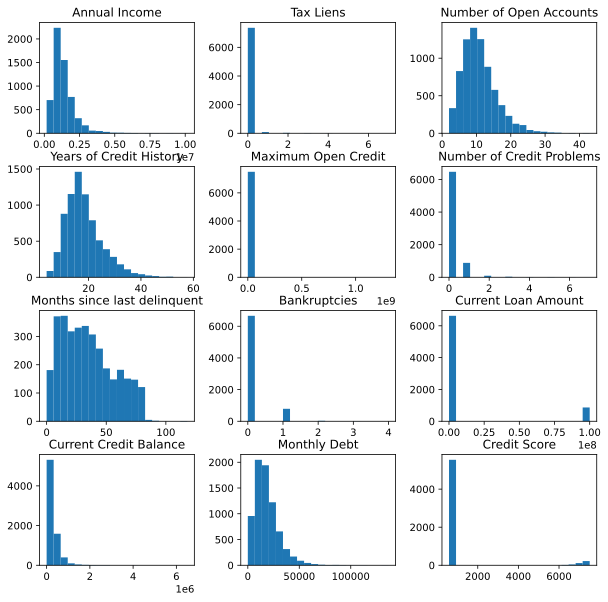

In [141]:
df[NUMERIC_FEATURES_NAME].hist(figsize=(10,10), bins=20, grid=False)

In [142]:
for i in NUMERIC_FEATURES_NAME:
    print('{} unique values:\t{}'.format(i,str(df[i].nunique())))

Annual Income unique values:	5478
Tax Liens unique values:	8
Number of Open Accounts unique values:	39
Years of Credit History unique values:	408
Maximum Open Credit unique values:	6963
Number of Credit Problems unique values:	8
Months since last delinquent unique values:	89
Bankruptcies unique values:	5
Current Loan Amount unique values:	5386
Current Credit Balance unique values:	6592
Monthly Debt unique values:	6716
Credit Score unique values:	268


Признаки **Tax Liens, Number of Credit Problems, Bankruptcies** имеют практически одинаковые диапазон значений и их можно рассмотреть как дамми,при обработке датасета.  

In [143]:
df[['Tax Liens','Number of Credit Problems']].corr()

Tax Liens  Number of Credit Problems
Tax Liens                   1.000000                   0.595339
Number of Credit Problems   0.595339                   1.000000

In [144]:
df[['Credit Default','Tax Liens','Number of Credit Problems']].corr()

Credit Default  Tax Liens  \
Credit Default                   1.000000   0.024368   
Tax Liens                        0.024368   1.000000   
Number of Credit Problems        0.020088   0.595339   

                           Number of Credit Problems  
Credit Default                              0.020088  
Tax Liens                                   0.595339  
Number of Credit Problems                   1.000000

Признаки **Tax Liens,Number of Credit Problems** имеют коэф.корреляции 0,59 между собой, однако с целевой переменной они слабо коррпелируют 0,24 и 0,2 соответственно. Необходимо проверить взаимосвязь признаков статистичексими методами.

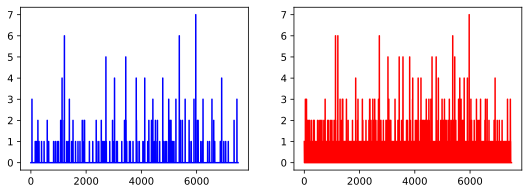

In [145]:
fig, ax = plt.subplots(nrows=1, ncols=2)

fig.set_size_inches(w = 9, h = 3)
fig.subplots_adjust(hspace=0.25)

ax[0].plot(df['Tax Liens'], color ='blue')
ax[1].plot(df['Number of Credit Problems'], color ='red')


Memory usage of dataframe is 0.04 MB
Memory usage after optimization is: 0.04 MB
Decreased by 0.0%


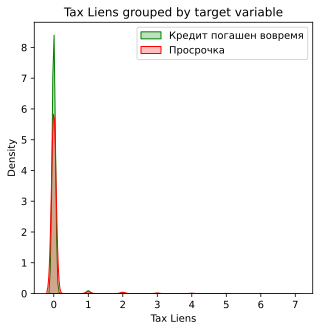

In [146]:
TaxLiens_with_target = df[['Tax Liens', TARGET_NAME[0]]]
TaxLiens = TaxLiens_with_target['Tax Liens']
TaxLiens_target_0 = TaxLiens[TaxLiens_with_target[TARGET_NAME[0]] == 0]
TaxLiens_target_1 = TaxLiens[TaxLiens_with_target[TARGET_NAME[0]] == 1]

reduce_mem_usage(TaxLiens_with_target)

plt.figure(figsize=(5, 5))

sns.kdeplot(TaxLiens_target_0, shade=True, label='Кредит погашен вовремя', color='g')

sns.kdeplot(TaxLiens_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Tax Liens')
plt.title('Tax Liens grouped by target variable')
plt.legend()
plt.show()

In [147]:
shapir_check(df,['Tax Liens'])

Признак: Tax Liens
	Statistics = 0.088
	p-value = 0.0
-----> Отклонить гипотезу о нормальности
**********************************************************************


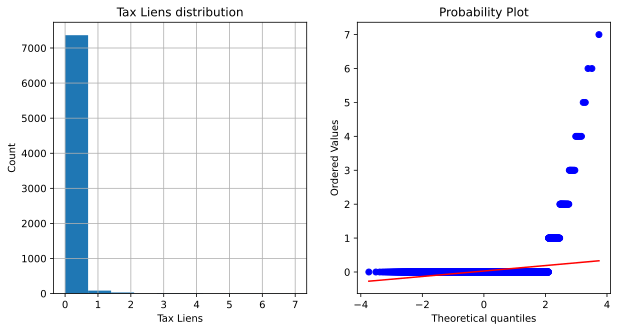

In [148]:
plt.figure(figsize=(10, 5))

ax1 = plt.subplot(121)
ax1.set_xlabel('Tax Liens')
ax1.set_ylabel('Count')
ax1.set_title('Tax Liens distribution')
TaxLiens.hist()

plt.subplot(122)
probplot(TaxLiens, dist='norm', plot=plt)

plt.show()

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака Tax Liens в группах с просроченным и непросроченным платеже. Воспользуемся его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения.

In [149]:
mannwhitneyu(TaxLiens_target_0, TaxLiens_target_1)

MannwhitneyuResult(statistic=5652588.5, pvalue=0.02256138327362573)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

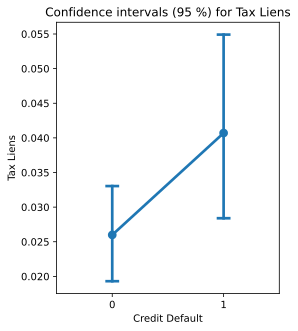

In [150]:
plt.figure(figsize=(4, 5))

sns.pointplot(x=TARGET_NAME[0], y='Tax Liens', data=TaxLiens_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Tax Liens')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп,практически не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.
Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (менее 95%), имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

In [151]:
def num_features_importance(df,numeric_feature):
    
    target_name = 'Credit Default'
              
    print('ПРОВЕРКА НА НОРМАЛЬНОСТЬ РАСПРЕДЕЛЕНИЯ')
      
    stat, p = shapiro(df[numeric_feature]) 
    alpha = 0.05
    print(f'Признак: {str(numeric_feature)}\n\tStatistics = {round(stat,3)}\n\tp-value = {round(p,4)}')
              
    if p > alpha:
         print('-----> Принять гипотезу о нормальности\n')
    else:
         print('-----> Отклонить гипотезу о нормальности\n')
  
 
    feature_with_target = df[[numeric_feature, target_name]]
    feature = feature_with_target[numeric_feature]
    feature_target_0 = feature[feature_with_target[target_name] == 0]
    feature_target_1 = feature[feature_with_target[target_name] == 1]

    plt.figure(figsize=(5, 5))

    sns.kdeplot(feature_target_0, shade=True, label='Кредит погашен вовремя', color='g')

    sns.kdeplot(feature_target_1, shade=True, label='Просрочка', color='r')

    plt.xlabel(numeric_feature)
    name = str(numeric_feature) + 'grouped by target variable'
    plt.title(name)
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(6, 7))

    sns.pointplot(x=target_name, y= numeric_feature, data=feature_with_target, capsize=.1)
    name2 = 'Confidence intervals (95 %) for '+ str(numeric_feature)
    plt.title(name2)
    plt.show()
                         
    print('МАН _УИТНИ ПРОВЕРКА:')
    man_result = mannwhitneyu(feature_target_0, feature_target_1)
    print(f'{man_result}\n{"*"*70}')

ПРОВЕРКА НА НОРМАЛЬНОСТЬ РАСПРЕДЕЛЕНИЯ
Признак: Annual Income
	Statistics = nan
	p-value = 1.0
-----> Принять гипотезу о нормальности



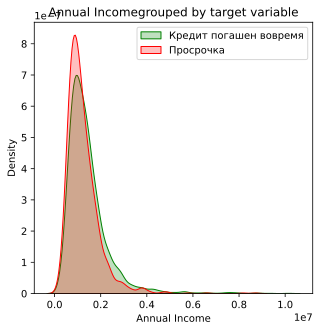

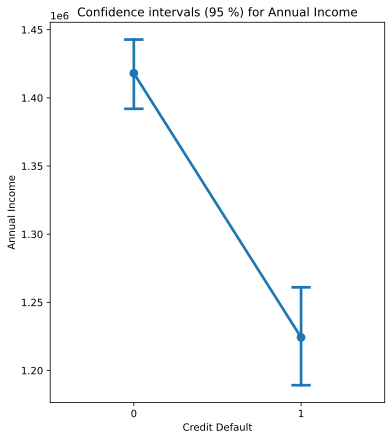

МАН _УИТНИ ПРОВЕРКА:
MannwhitneyuResult(statistic=5534342.5, pvalue=0.031334788783133206)
**********************************************************************
ПРОВЕРКА НА НОРМАЛЬНОСТЬ РАСПРЕДЕЛЕНИЯ
Признак: Number of Open Accounts
	Statistics = 0.937
	p-value = 0.0
-----> Отклонить гипотезу о нормальности



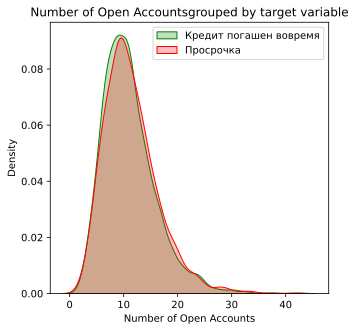

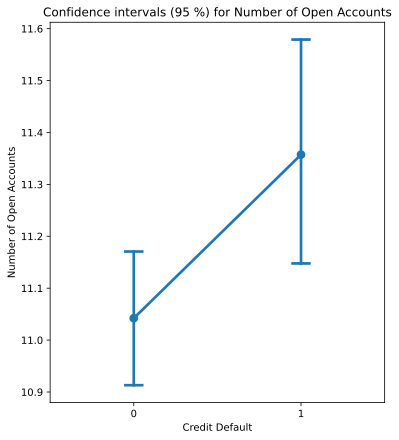

МАН _УИТНИ ПРОВЕРКА:
MannwhitneyuResult(statistic=5466480.0, pvalue=0.003761646078803518)
**********************************************************************
ПРОВЕРКА НА НОРМАЛЬНОСТЬ РАСПРЕДЕЛЕНИЯ
Признак: Years of Credit History
	Statistics = 0.943
	p-value = 0.0
-----> Отклонить гипотезу о нормальности



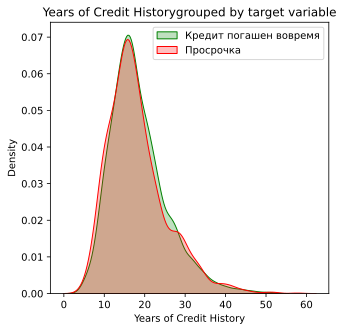

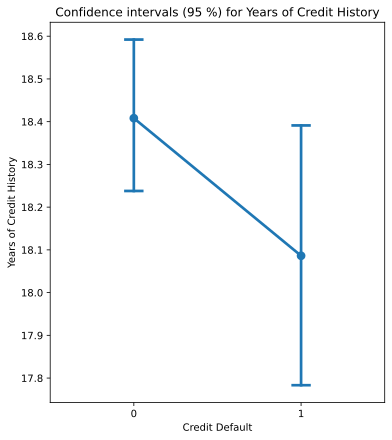

МАН _УИТНИ ПРОВЕРКА:
MannwhitneyuResult(statistic=5461129.5, pvalue=0.003171215731103466)
**********************************************************************
ПРОВЕРКА НА НОРМАЛЬНОСТЬ РАСПРЕДЕЛЕНИЯ
Признак: Maximum Open Credit
	Statistics = 0.01
	p-value = 0.0
-----> Отклонить гипотезу о нормальности



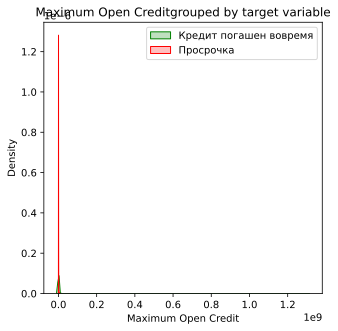

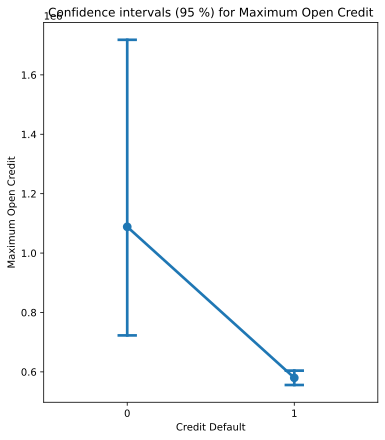

МАН _УИТНИ ПРОВЕРКА:
MannwhitneyuResult(statistic=5230602.0, pvalue=2.3483604148529427e-08)
**********************************************************************
ПРОВЕРКА НА НОРМАЛЬНОСТЬ РАСПРЕДЕЛЕНИЯ
Признак: Number of Credit Problems
	Statistics = 0.375
	p-value = 0.0
-----> Отклонить гипотезу о нормальности



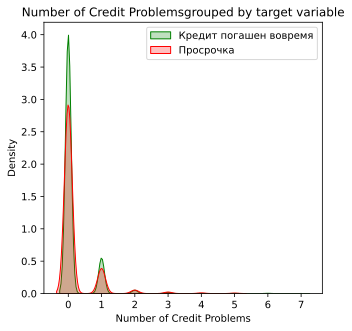

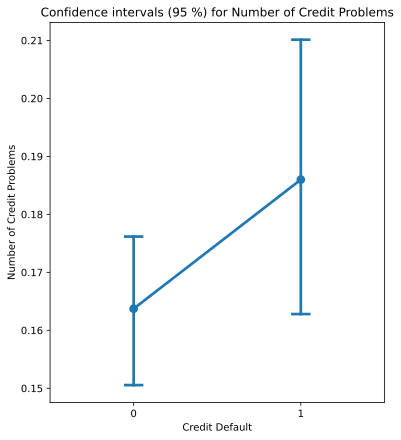

МАН _УИТНИ ПРОВЕРКА:
MannwhitneyuResult(statistic=5655742.5, pvalue=0.23974551535317956)
**********************************************************************
ПРОВЕРКА НА НОРМАЛЬНОСТЬ РАСПРЕДЕЛЕНИЯ
Признак: Months since last delinquent
	Statistics = nan
	p-value = 1.0
-----> Принять гипотезу о нормальности



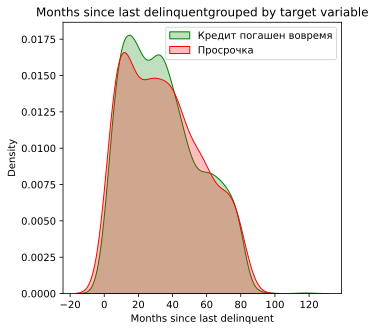

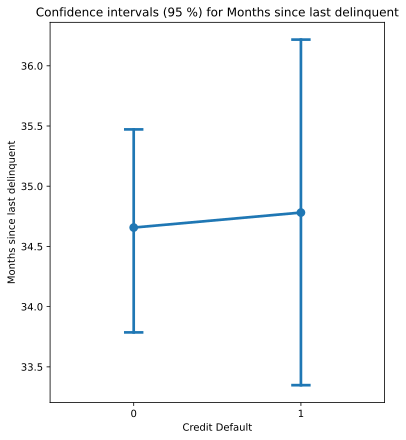

МАН _УИТНИ ПРОВЕРКА:
MannwhitneyuResult(statistic=4187753.5, pvalue=2.2303574646660457e-71)
**********************************************************************
ПРОВЕРКА НА НОРМАЛЬНОСТЬ РАСПРЕДЕЛЕНИЯ
Признак: Bankruptcies
	Statistics = nan
	p-value = 1.0
-----> Принять гипотезу о нормальности



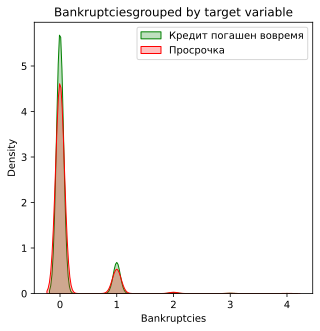

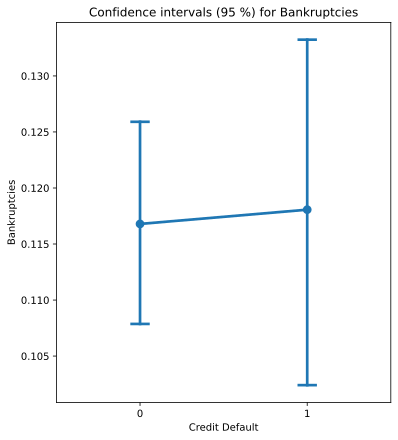

МАН _УИТНИ ПРОВЕРКА:
MannwhitneyuResult(statistic=5686353.0, pvalue=0.4567074598086799)
**********************************************************************
ПРОВЕРКА НА НОРМАЛЬНОСТЬ РАСПРЕДЕЛЕНИЯ
Признак: Current Loan Amount
	Statistics = 0.377
	p-value = 0.0
-----> Отклонить гипотезу о нормальности



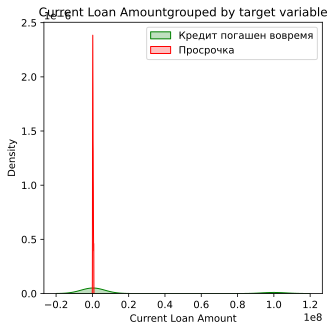

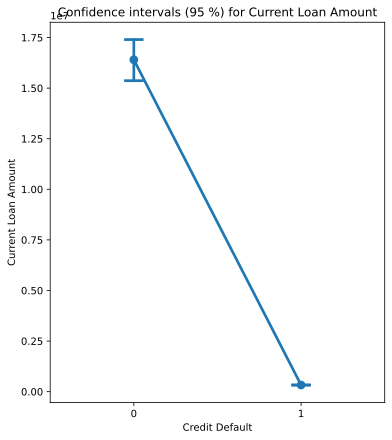

МАН _УИТНИ ПРОВЕРКА:
MannwhitneyuResult(statistic=5169258.0, pvalue=2.923443678733522e-10)
**********************************************************************
ПРОВЕРКА НА НОРМАЛЬНОСТЬ РАСПРЕДЕЛЕНИЯ
Признак: Current Credit Balance
	Statistics = 0.639
	p-value = 0.0
-----> Отклонить гипотезу о нормальности



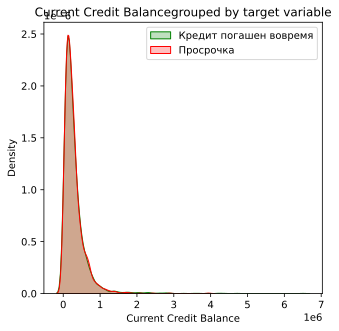

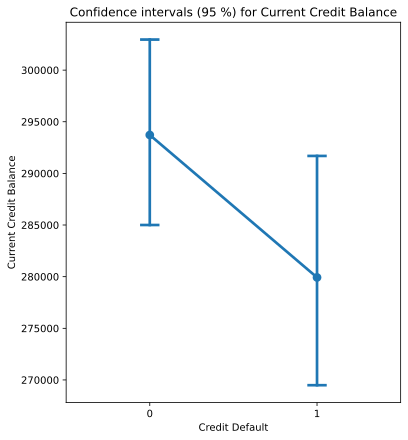

МАН _УИТНИ ПРОВЕРКА:
MannwhitneyuResult(statistic=5687957.0, pvalue=0.48388614709675304)
**********************************************************************
ПРОВЕРКА НА НОРМАЛЬНОСТЬ РАСПРЕДЕЛЕНИЯ
Признак: Monthly Debt
	Statistics = 0.894
	p-value = 0.0
-----> Отклонить гипотезу о нормальности



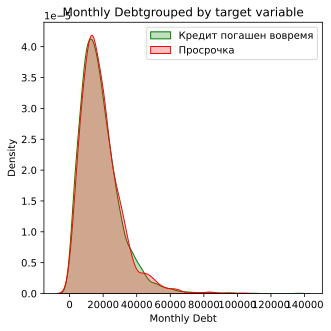

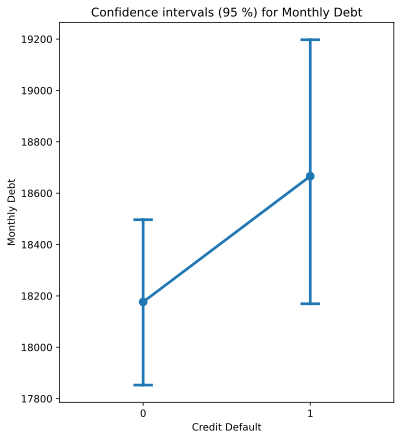

МАН _УИТНИ ПРОВЕРКА:
MannwhitneyuResult(statistic=5534935.5, pvalue=0.03183394406726229)
**********************************************************************
ПРОВЕРКА НА НОРМАЛЬНОСТЬ РАСПРЕДЕЛЕНИЯ
Признак: Credit Score
	Statistics = nan
	p-value = 1.0
-----> Принять гипотезу о нормальности



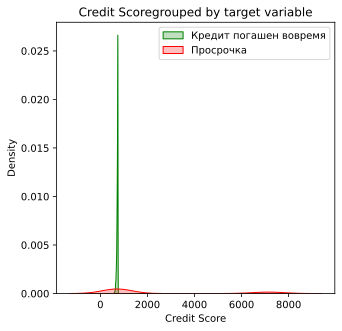

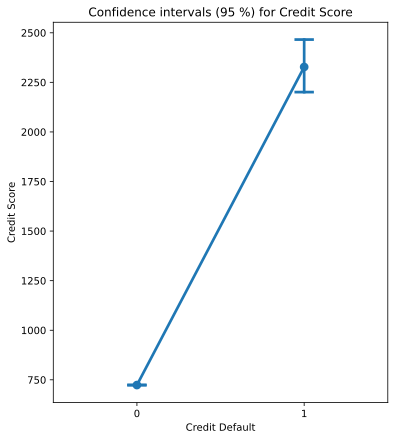

МАН _УИТНИ ПРОВЕРКА:
MannwhitneyuResult(statistic=5197665.0, pvalue=2.4094608408145815e-09)
**********************************************************************


In [152]:
lst =NUMERIC_FEATURES_NAME.copy()
ind = NUMERIC_FEATURES_NAME.index('Tax Liens')
lst.pop(ind)

for i in range(len(lst)):
    num_features_importance(df,str(lst[i]))   

In [153]:
df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
Id                                 0
dtype: int64

По результатм проверик на нормальность методом ШАпиро-Уилка,работающего только над вещественными данными, было показаночто следующие признаки имеют нормальное распределение:

1. Annual Income (но наблюдаются Statistics = nan)
2. Months since last delinquent (но наблюдаются Statistics = nan)
3. Bankruptcies (но наблюдаются Statistics = nan)
4. Credit Score (но наблюдаются Statistics = nan)

- У признаков выше наблюдаются пропущенные значения, поэтому статистику Шапиро Уилка не удалось рассчитать.Но по графикам распределн6ия видно,что распределение не нормальное.

---
К отличным от нормального отнесены остальные признаки:
1. Number of Open Accounts
2. Years of Credit History
3. Maximum Open Credit
4. Number of Credit Problems
5. Current Loan Amount
6. Current Credit Balance
7. Monthly Debt

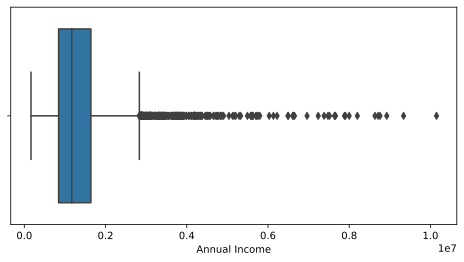

Начать обратоку выбросов со значения: 2833831.0
**********************************************************************


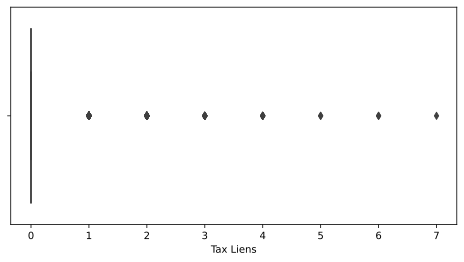

Начать обратоку выбросов со значения: 0.0
**********************************************************************


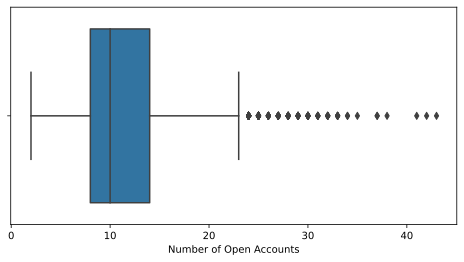

Начать обратоку выбросов со значения: 23.0
**********************************************************************


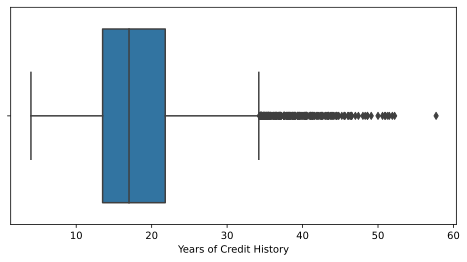

Начать обратоку выбросов со значения: 34.24999809265137
**********************************************************************


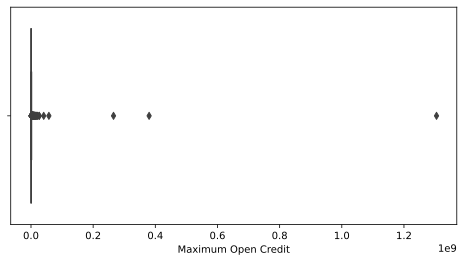

Начать обратоку выбросов со значения: 1564909.5
**********************************************************************


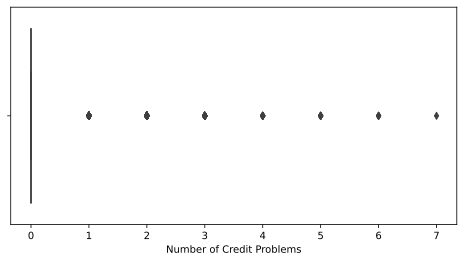

Начать обратоку выбросов со значения: 0.0
**********************************************************************


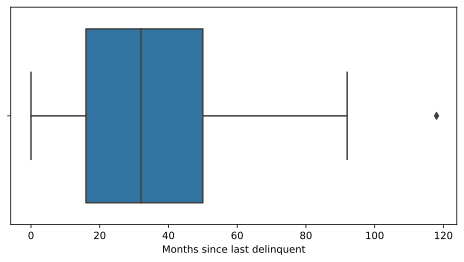

Начать обратоку выбросов со значения: 101.0
**********************************************************************


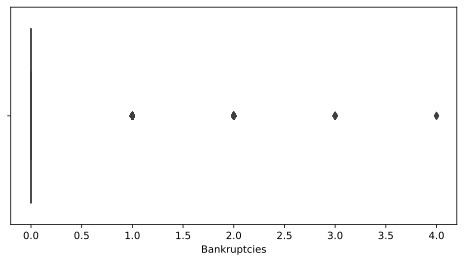

Начать обратоку выбросов со значения: 0.0
**********************************************************************


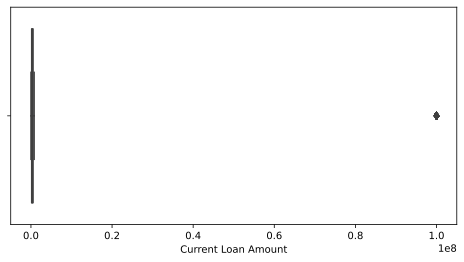

Начать обратоку выбросов со значения: 1029451.5
**********************************************************************


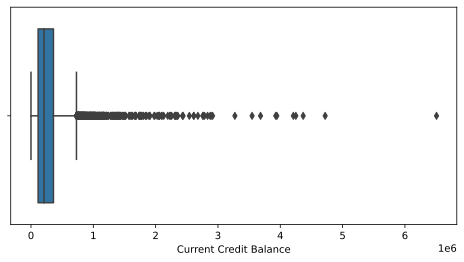

Начать обратоку выбросов со значения: 729630.875
**********************************************************************


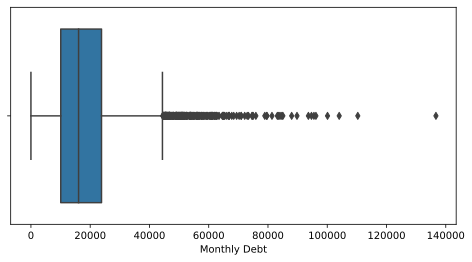

Начать обратоку выбросов со значения: 44443.75
**********************************************************************


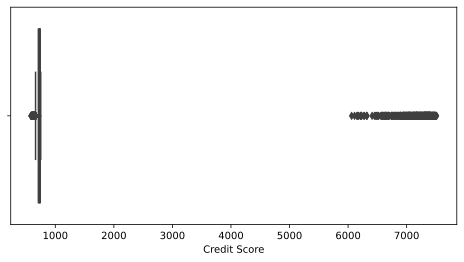

Начать обратоку выбросов со значения: 791.0
**********************************************************************


In [154]:
for i in range(len(NUMERIC_FEATURES_NAME)):
           
    plt.figure(figsize=(8, 4))
    sns.boxplot(df[NUMERIC_FEATURES_NAME[i]], whis=1.5)

    plt.xlabel(NUMERIC_FEATURES_NAME[i])
    plt.show()
    
    q1 = df[NUMERIC_FEATURES_NAME[i]].quantile(0.25)
    q3 = df[NUMERIC_FEATURES_NAME[i]].quantile(0.75)

    IQR = q3 - q1

    lower_fence = q1 - (1.5 * IQR)
    upper_fence = q3 + (1.5 * IQR)
    
    print(f'Начать обратоку выбросов со значения: {upper_fence}\n{"*"*70}')

**Выбросы** замечены у переменных Annual Income, Years of Credit History, Current Credit Balance, Monthly Debt,Credit Score.

**Бинарными или категориальными признаками могут быть** признаки Tax Liens,Maximum Open Credit,Number of Credit Problems, Bankruptcies

In [155]:
df_copy = df.copy()
outliers_features_list = ['Annual Income','Years of Credit History',
                          'Current Credit Balance','Monthly Debt','Credit Score']

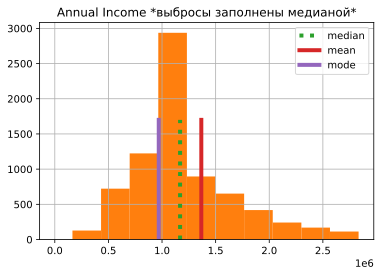

Признак: Annual Income
	Statistics = 0.934
	p-value = 0.0
-----> Отклонить гипотезу о нормальности
**********************************************************************


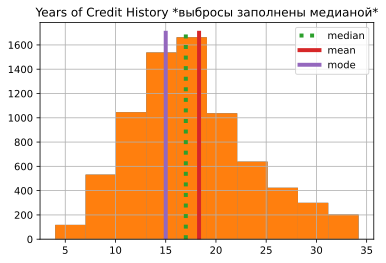

Признак: Years of Credit History
	Statistics = 0.975
	p-value = 0.0
-----> Отклонить гипотезу о нормальности
**********************************************************************


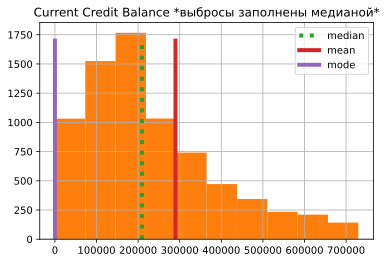

Признак: Current Credit Balance
	Statistics = 0.928
	p-value = 0.0
-----> Отклонить гипотезу о нормальности
**********************************************************************


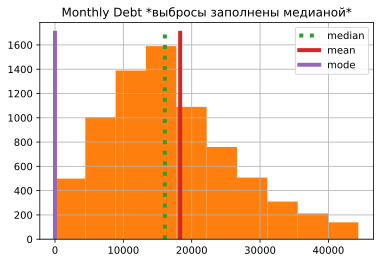

Признак: Monthly Debt
	Statistics = 0.968
	p-value = 0.0
-----> Отклонить гипотезу о нормальности
**********************************************************************


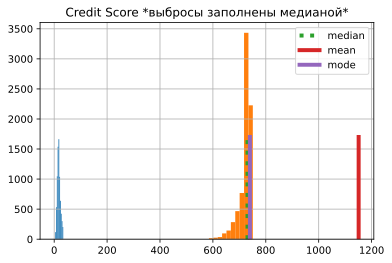

Признак: Credit Score
	Statistics = 0.785
	p-value = 0.0
-----> Отклонить гипотезу о нормальности
**********************************************************************


In [156]:
for i in range (len(outliers_features_list)):
   
    #1. Основные статистики признаков с явными выбросами
    feat_med = df_copy[outliers_features_list[i]].median()
    feat_mean = round(df_copy[outliers_features_list[i]].mean(),2)
    feat_mod = df_copy[outliers_features_list[i]].mode()[0]
    
    #2. Расчет границы размаха для поиска начальной точки выброса BoxPlot
    q1 = df_copy[outliers_features_list[i]].quantile(0.25)
    q3 = df_copy[outliers_features_list[i]].quantile(0.75)

    IQR = q3 - q1
    lower_fence = q1 - (1.5 * IQR)
    upper_fence = q3 + (1.5 * IQR)                   

    # 3. Обработка выброса по значению из box-plot выше
    df_copy.loc[df_copy[outliers_features_list[i]] > upper_fence, outliers_features_list[i]] = feat_med
    
    # 4. Обработка пропусков если есть медианными значениями
    df_copy[outliers_features_list[i]].fillna(feat_med, inplace = True)
    df_copy['Years of Credit History'].hist()

    # 5 Гистограмма распределения признака (выбросы и пропуски = медиана)
    df_copy[outliers_features_list[i]].hist()
    y = np.linspace(0, 1700, 10)

    plt.plot([feat_med]*10, y, label='median',linestyle=':', linewidth=4)
    plt.plot([feat_mean]*10, y, label='mean', linewidth=4)
    plt.plot([feat_mod]*10, y, label='mode', linewidth=4)
    name = str(outliers_features_list[i])+ ' *выбросы заполнены медианой*'
    plt.title(name)

    plt.legend()
    plt.show()

    # 5. Проверка на нормальность по Шапиро-Уилку
    shapir_check(df_copy,[outliers_features_list[i]]) 

Как видим, все рассмотренные признаки лучше оставить,т.к их рапредление отличается от нормального и может оказывать влияние на целевую переменную. При это, заполняя медианными значения пропуски и зхаменя выбросы, в признаках мы достигаем хороше близости к нормальному распределению.

Прооведем анализ некоторых сомнительных числовых переменных:

1. Maximum Open Credit (наибольший открытый кредит)
2. Number of Credit Problems (количество проблем с кредитом)
3. Bankruptcies (банкротства)
4. Current Loan Amount (текущая сумма кредита)

In [157]:
suspected_feature_list = ['Maximum Open Credit','Number of Credit Problems','Current Loan Amount','Bankruptcies']
df_copy[suspected_feature_list].describe()

Maximum Open Credit  Number of Credit Problems  Current Loan Amount  \
count         7.500000e+03                  7500.0000               7500.0   
mean          9.451526e+05                     0.1700           11873135.0   
std           1.602614e+07                     0.4986           31926302.0   
min           0.000000e+00                     0.0000              11242.0   
25%           2.792295e+05                     0.0000             180169.0   
50%           4.781590e+05                     0.0000             309573.0   
75%           7.935015e+05                     0.0000             519882.0   
max           1.304726e+09                     7.0000          100000000.0   

       Bankruptcies  
count   7486.000000  
mean       0.117152  
std        0.347197  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        4.000000

In [158]:
df_copy['Maximum Open Credit'].value_counts()

0.0          65
319110.0      5
334796.0      3
607046.0      3
294030.0      3
             ..
534600.0      1
1026124.0     1
77066.0       1
780164.0      1
350768.0      1
Name: Maximum Open Credit, Length: 6963, dtype: int64

In [159]:
for i in range(len(suspected_feature_list)):
    name = suspected_feature_list[i]
    feature = df_copy[suspected_feature_list[i]]
    print(f'{str(name)}:\nMEDIAN: {feature.median()}\nMODE: {feature.mode()[0]}\nMEAN: {feature.mean()}\n{"*"*70}')

Maximum Open Credit:
MEDIAN: 478159.0
MODE: 0.0
MEAN: 945152.625
**********************************************************************
Number of Credit Problems:
MEDIAN: 0.0
MODE: 0.0
MEAN: 0.17000000178813934
**********************************************************************
Current Loan Amount:
MEDIAN: 309573.0
MODE: 100000000.0
MEAN: 11873135.0
**********************************************************************
Bankruptcies:
MEDIAN: 0.0
MODE: 0.0
MEAN: 0.11715202033519745
**********************************************************************


In [160]:
df_credit = pd.DataFrame(data = df_copy.loc[df_copy['Maximum Open Credit'] == 0,
                                        ['Current Loan Amount','Months since last delinquent','Years of Credit History',
                                         'Credit Score', 'Number of Open Accounts','Purpose']])
df_credit.describe()

Current Loan Amount  Months since last delinquent  \
count                 65.0                     35.000000   
mean            14070644.0                     35.285713   
std             34716988.0                     21.893555   
min                11242.0                      0.000000   
25%               112728.0                     15.500000   
50%               244684.0                     38.000000   
75%               460394.0                     50.000000   
max            100000000.0                     77.000000   

       Years of Credit History  Credit Score  Number of Open Accounts  
count                65.000000     65.000000                65.000000  
mean                 16.900000    728.892334                 7.569231  
std                   4.347449     20.674650                 3.724787  
min                   8.800000    657.000000                 2.000000  
25%                  14.200000    731.000000                 5.000000  
50%                  17.000000    731.000000                 7.000000  
75%                  19.100000    742.000000                 9.000000  
max                  32.799999    751.000000                19.000000

In [161]:
print(f'Current Loan Amount:\nMODE: {df_credit["Current Loan Amount"].mode()[0]}')
print(f'MEDIAN: {df_credit["Current Loan Amount"].median()}')
print(f'MEAN: {df_credit["Current Loan Amount"].mean()}')
print(f'{"*"*70}')
print(f'Months since last delinquent:\nMODE: {df_credit["Months since last delinquent"].mode()[0]}')
print(f'MEDIAN: {df_credit["Months since last delinquent"].median()}')
print(f'MEAN: {df_credit["Months since last delinquent"].mean()}')

Current Loan Amount:
MODE: 100000000.0
MEDIAN: 244684.0
MEAN: 14070644.0
**********************************************************************
Months since last delinquent:
MODE: 41.0
MEDIAN: 38.0
MEAN: 35.28571319580078


1. Получается, что при значении максимально открытого кредита равного нулю (0) - максимальная величина текущего кредита  составляет 100 000 000 рублей и она же является модой в данной выборке. Медианное значение 244 684 руб. при среднем 14 070 644 рублей. 
2. Так же при нулевых значениях, кол-во месяцев с последней просрочки платежа составляет 41 месяц(мода выборки) и 38 месяцев -медианное значение.
* *Впричинах взятия кредита так же числится консолидация долгов и большое кол-во счетов*

In [162]:
df_problem = pd.DataFrame(
    data = df_copy.loc[df_copy['Number of Credit Problems'] == 0,
                       ['Bankruptcies','Months since last delinquent','Monthly Debt','Credit Score']])
df_problem.describe()

Bankruptcies  Months since last delinquent  Monthly Debt  Credit Score
count        6455.0                   2912.000000   6469.000000   6469.000000
mean            0.0                     33.314217  17133.482422    723.885132
std             0.0                     21.191076   9336.927734     24.010159
min             0.0                      0.000000      0.000000    585.000000
25%             0.0                     15.000000  10167.000000    719.000000
50%             0.0                     31.000000  16076.500000    731.000000
75%             0.0                     47.000000  22679.000000    738.000000
max             0.0                    118.000000  44382.000000    751.000000

In [163]:
print(f'Months since last delinquent:\nMODE: {df_problem["Months since last delinquent"].mode()[0]}')
print(f'MEDIAN: {df_problem["Months since last delinquent"].median()}')
print(f'MEAN: {df_problem["Months since last delinquent"].mean()}')

Months since last delinquent:
MODE: 14.0
MEDIAN: 31.0
MEAN: 33.31421661376953


Как видно из таблицы выше, что при отсутствии проблем с кредитом (0),количество месяцев с последней просрочки платежа максимально достигает более 10 лет (118 месяцев). При этом частым значением является показатель в 14 месяцев, а медианное значение - 31 месяц.

### ВЫВОДЫ АНАЛИЗА КОЛИЧЕСТВЕННЫХ ПРИЗНАКОВ <a class ='anchor' id ='numeric_sum'>

**ОБРАБОТКА ПРОПУСКОВ** (заполнение медианными значениями)

1. **Annual Income** (годовой доход) 5943/7500
2. **Months since last delinquent** (количество месяцев с последней просрочки платежа) 3419 /7500
3. **Bankruptcies** (банкротства) 7486 /7500
4. **Credit Score** (баллы кредитного рейтинга) 5943 /7500
 
---
**ОБРАБОТКА ВЫБРОСОВ** - *для обработки будем использовать расчет верхней границы 1,5 квартильного размаха и заполнять выбросы медианными значениям для признаков ниже:                

1. **Annual Income** (годовой доход) 
2. **Years of Credit History** (количество лет кредитной истории)
3. **Current Credit Balance** (текущий кредитный баланс)
4. **Monthly Debt** (ежемесячный долг)
5. **Credit Score** (баллы кредитного рейтинга)

---
**ОБРАБОТКА ЛОГИЧЕСКИХ НЕСООТВЕСТВИЙ ПОСЛЕ ОБРАБОТКИ ВЫБРОСОВ**
* Для переменных ниже, будем заменять значения равные нулю (0) на медианные значения:
1. **Maximum Open Credit** (наибольший открытый кредит)
---

### Анализ целевой переменной <a class ='anchor' id = 'TARGET_NAME'>

In [164]:
df[TARGET_NAME[0]].value_counts() #  Проверка на дисбаланс классов

0    5387
1    2113
Name: Credit Default, dtype: int64

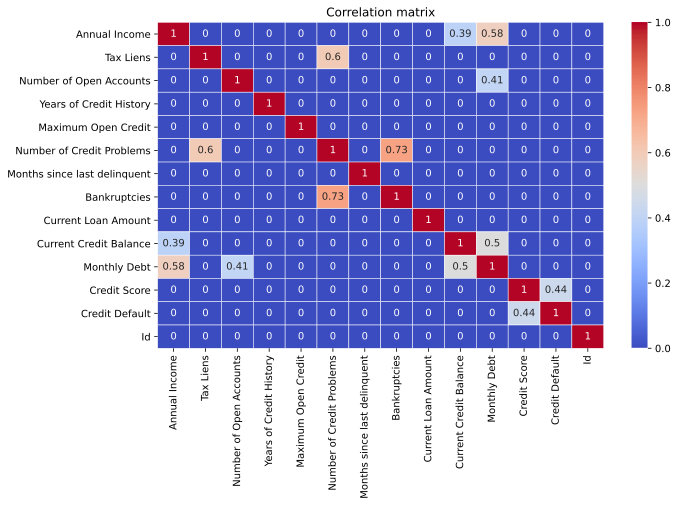

In [165]:
plt.figure(figsize = (10,6))

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Наблюдается дисбаланс классов целевой переменной с преобладанием класса 0 - *кредит погашен вовремя* в процентном соотношении 72% против 28%. Наиболее линейно зависимым признаком для целевой перемнной является **Credit Score (corr =0.44)**

### РЕЗУЛЬТАТЫ  АНАЛИЗА  ПРИЗНАКОВ ДЛЯ РАЗБИЕНИЯ И ОБУЧЕНИЯ <a class ='anchor' id ='conclusion'>

**ОБЪЕДЕНЕНИЕ КАТЕГОРИЙ ПРИЗНАКОВ В НОВЫЕ ГРУППЫ/КАТЕГОРИИ (Хи-квадрат)**(CATEGORY_FEATURES_NAME)

1. **Home Ownership** - признак разбиваем на три (3) категории/группы существующих 4-х категорий признака:
    * **Group1** - включает **Rent , Have Mortage**
    * **Group2** - включает **Own Home**
    * **Group3**-  включает **Home Mortgage**  
    

2. **Years in current job** - признак разбиваем на четыре (4) категории/группы существующих 11-и категорий признака:
    * **Group1** - включает **1 year, 4 years, 5 years, 6 years, 7 years, 8 years, 10+ years**
    * **Group2** - включает **2 years**
    * **Group3**-  включает **< 1 year,3 years**
    * **Group4**-  включает **9 years**  
    

3. **Purpose** - признак разбиваем на пять (5) категорий/групп существующих 15-и категорий признака:
    * **Group1** - включает **business loan, small business**
    * **Group2** - включает **medical bills**
    * **Group3**-  включает **other','debt consolidation', 'take a trip**
    * **Group4**-  включает **home improvements, buy a car, major purchase,buy house, wedding, moving, educational expenses,vacation**
    * **Group5**-  включает **renewable energy**
---

**ПЕРЕВОД КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ В БИНАНРНЫЙ ФОРМАТ**(CATEGORY_FEATURES_NAME)
1. **Term** - признак переводим в бинарный формат:
    * **0** - для значения **Short Term**
    * **1** - для значения **Long Term**
---

**ОБРАБОТКА ПРОПУСКОВ ПРИЗНАКОВ ИСХОДНОГО ДАТАСЕТА:**  

Заполняем медианными значениями:

1. **КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ** (CATEGORY_FEATURES_NAME) 
 * **Years in current job**  заполнено данными 7129 /7500

2. **КОЛИЧЕСТВЕННЫЕ/БИНАРНЫЕ ПРИЗНАКИ** (NUMERIC_FEATURES_NAME)
    * **Annual Income** (годовой доход) 5943/7500
    * **Months since last delinquent** (количество месяцев с последней просрочки платежа) 3419 /7500
    * **Bankruptcies** (банкротства) 7486 /7500
    * **Credit Score** (баллы кредитного рейтинга) 5943 /7500
---

**ОБРАБОТКА ВЫБРОСОВ** - для обработки будем использовать расчет верхней границы 1,5 квартильного размаха и заполнять выбросы медианными значениям для признаков ниже:              

1. **Annual Income** (годовой доход) 
2. **Years of Credit History** (количество лет кредитной истории)
3. **Current Credit Balance** (текущий кредитный баланс)
4. **Monthly Debt** (ежемесячный долг)
5. **Credit Score** (баллы кредитного рейтинга)

---
**ОБРАБОТКА ЛОГИЧЕСКИХ НЕСООТВЕСТВИЙ ПОСЛЕ ОБРАБОТКИ ВЫБРОСОВ**  

Для переменной ниже, будем заменять значения равные нулю (0) на медианные значения:
1. **Maximum Open Credit** (наибольший открытый кредит)
---
    

## Подготовка датасетов на базе train.csv <a class = 'anchor' id ='2'>

Данный этап будет состоять из следующего набора действий:
1. **Масштабируем (нормализуем) количественные перемнные исходного датасета train.csv** и сохраняем его в путь SCALER_FILE_PATH как scaler.pkl
2. **Формируем список признаков,который оставляем для обучения и подбора модели как важные** (включая новые фичиесли они были созданы) и сохранем их в список перемнной ***SELECTED_FEATURE_NAMES***.
3. Разбиваем исходный датасет файла train.csv на две части:
    * **train_part** - часть исходного датасета,которая будет подвержена предобработке данных на основании результатов анализа перемнных.
    * **test_part** - часть исходного датасета,которая **НЕ БУДЕТ подвержена предобработке данных** на основании результатов анализа перемнных
    * **train_full** - трейн часть исходного датасета фалйа train.csv, МАСШАТБИРОВАННАЯ, но которая ЕЩЕ НЕ ПОДВЕРЖЕНА ПРЕДОБРАБОТКЕ ДАННЫХ на основании результатов анализа перемнных, и сохранена в путь TRAIN_FULL_PATH под именем 'train_full.csv'
   
4. Создание функции предобработки данных (DataPipeline) для трейн части датасета train.csv, которая так же будет применяться к финальному тестову датасету из файла test.csv.
  
5. Применение DataPiple к train_part_balanced перед использования тренировочной части и тестовой части на этапе выбора модели.

6. **Устанение дисбаланса классов для train_part** файла train.csv с помощью скрипта ***balance_df_by_target***
7. Сохранение тренировочной части исходного датасета  после устранения дисбаланса классов:
    * **train_part_balanced** - часть исходного датасета,которая будет подвержена предобработке данных на основании результатов анализа перемнных, и сохранена после устранени ядисбаланса классов в путь TRAIN_PART_PATH  под именем ***'train_part_balanced.csv'***


**Масштабирование данных**

In [166]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUMERIC_FEATURES_NAME] = scaler.fit_transform(df_norm[NUMERIC_FEATURES_NAME])


In [167]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

**Разбиение датасета на тренировочный

In [168]:
# Проверка,что датасет исходный не изменен
print(df.shape)
df.info()

(7500, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 no

### Cохранение датасетов <a class = 'anchor' id = 'train_test_save'>

In [169]:
SELECTED_FEATURE_NAMES = BASE_FEATURES_NAME
SELECTED_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [170]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [171]:
test_part = pd.concat([X_test, y_test], axis=1)
train_part = pd.concat([X_train, y_train], axis=1)
train_full = df_norm.copy() #сохранение маштабированной train части датасета train.csv

In [173]:
train_full.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train_part.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test_part.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

### Data Pipeline функция для обработки train_part of train.csv<a class ='anchor' id ='data_piple'>

Функция обработки тренировочных данных будет опираться на результаты анализа, рассмотренные выше (см. ***[РЕЗУЛЬТАТЫ  АНАЛИЗА  ПРИЗНАКОВ ДЛЯ РАЗБИЕНИЯ И ОБУЧЕНИЯ](#conclusion)***)

In [ ]:
class DataPipeline:
        
    def __init__(self):
       
        self.medians = None
       
        
    def fit(self, df):
       
        #Рассчет основых статистик
                     
        mask = df.isna().sum() > 0
        zero_column_list = df.columns[mask].tolist()
        print('Столбцы с пустыми данными:{}'.format(zero_column_list)
              
        outliers_features_list = ['Annual Income','Years of Credit History','Current Credit Balance',
                                  'Monthly Debt','Credit Score']
              
        self.medians = df[zero_column_list].median()
        self.medians_outliers = df[outliers_features_list].median()
              
                  
    def transform(self, df):
        
        #1. Заполняем пропуски медианными значениями
        mask = df.isna().sum() > 0
        zero_column_list = df.columns[mask].tolist()
        
        df[zero_column_list] = df[zero_column_list].fillna(self.medians)
       
        #2. Объединяем  значения категориальных признаков в группы
        category_features_group_list = ['Home Ownership', 'Years in current job','Purpose']     
        category_features_bin = 'Term'
        
        
        df.loc[df[category_features_group_list[0]].isin([-1, 0]),category_features_group_list[0]] = 0
        df.loc[df[category_features_group_list[0]].isin([2, 3]), category_features_group_list[0]] = 2
            
        
              
        # Перевод признака  в бинарный формат (0- Short Term,1 -Long Term)
        
        df.iloc[df[category_features_bin]=="Short Term",'category_features_bin'] == 0
        df.iloc[df[category_features_bin]=="Long Term",'category_features_bin'] == 1      
        
        #3. Обрабатываем выбросы    
        
        outliers_features_list = ['Annual Income','Years of Credit History','Current Credit Balance',
                                  'Monthly Debt','Credit Score']     
        
        for i in range (len(outliers_features_list)):
       
            #Расчет границы размаха для поиска начальной точки выброса BoxPlot
            q1 = df[outliers_features_list[i]].quantile(0.25)
            q3 = df_copy[outliers_features_list[i]].quantile(0.75)

            IQR = q3 - q1
            lower_fence = q1 - (1.5 * IQR)
            upper_fence = q3 + (1.5 * IQR)                   

            # Обработка выброса по значению из box-plot выше
            
            df.loc[(df[outliers_features_list[i]] > upper_fence) || (df[outliers_features_list[i]] < lower_fence),
                   outliers_features_list[i]] = self.medians_outliers
          
               
        #4. Отброс не нужного параметра ID
        df = df.drop('Id', axis =1)
    
        return df
        


In [ ]:
**ОБЪЕДЕНЕНИЕ КАТЕГОРИЙ ПРИЗНАКОВ В НОВЫЕ ГРУППЫ/КАТЕГОРИИ (Хи-квадрат)**(CATEGORY_FEATURES_NAME)

1. **Home Ownership** - признак разбиваем на три (3) категории/группы существующих 4-х категорий признака:
    * **Group1** - включает **Rent , Have Mortage**
    * **Group2** - включает **Own Home**
    * **Group3**-  включает **Home Mortgage**  
    

2. **Years in current job** - признак разбиваем на четыре (4) категории/группы существующих 11-и категорий признака:
    * **Group1** - включает **1 year, 4 years, 5 years, 6 years, 7 years, 8 years, 10+ years**
    * **Group2** - включает **2 years**
    * **Group3**-  включает **< 1 year,3 years**
    * **Group4**-  включает **9 years**  
    

3. **Purpose** - признак разбиваем на пять (5) категорий/групп существующих 15-и категорий признака:
    * **Group1** - включает **business loan, small business**
    * **Group2** - включает **medical bills**
    * **Group3**-  включает **other','debt consolidation', 'take a trip**
    * **Group4**-  включает **home improvements, buy a car, major purchase,buy house, wedding, moving, educational expenses,vacation**
    * **Group5**-  включает **renewable energy**
---

**ПЕРЕВОД КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ В БИНАНРНЫЙ ФОРМАТ**(CATEGORY_FEATURES_NAME)
1. **Term** - признак переводим в бинарный формат:
    * **0** - для значения **Short Term**
    * **1** - для значения **Long Term**
---

### Обработка дисбаланса классов целевой переменной train_part of train.csv<a class = 'anchor' id ='disbalance_train'>

In [174]:
y_train.value_counts()

0    3771
1    1479
Name: Credit Default, dtype: int64

In [175]:
df_train_full = pd.read_csv(TRAIN_FULL_PATH)
df_train = pd.read_csv(TRAIN_PART_PATH)
df_test = pd.read_csv(TEST_PART_PATH)

In [178]:
df_train

Home Ownership  Annual Income Years in current job  Tax Liens  \
0     Home Mortgage       682898.0                  NaN        0.0   
1     Home Mortgage       786353.0            10+ years        0.0   
2              Rent      1158354.0              2 years        0.0   
3     Home Mortgage      1168595.0            10+ years        0.0   
4     Home Mortgage            NaN              5 years        0.0   
...             ...            ...                  ...        ...   
5245  Home Mortgage            NaN              8 years        0.0   
5246  Home Mortgage            NaN            10+ years        0.0   
5247  Home Mortgage      2365367.0              5 years        0.0   
5248  Home Mortgage       855969.0            10+ years        0.0   
5249           Rent            NaN              2 years        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                         9.0                     29.5             565664.0   
1                         9.0                      9.6             160490.0   
2                        11.0                     23.0             225412.0   
3                        15.0                     17.5             536998.0   
4                         9.0                     11.4             203390.0   
...                       ...                      ...                  ...   
5245                     14.0                     18.7             252670.0   
5246                      8.0                     16.9             694562.0   
5247                     16.0                     23.6            3007136.0   
5248                     10.0                     22.0             484990.0   
5249                     10.0                     10.3             214038.0   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                           0.0                          10.0           0.0   
1                           0.0                           NaN           0.0   
2                           0.0                          14.0           0.0   
3                           0.0                           NaN           0.0   
4                           0.0                           NaN           0.0   
...                         ...                           ...           ...   
5245                        0.0                          29.0           0.0   
5246                        0.0                           NaN           0.0   
5247                        0.0                           NaN           0.0   
5248                        0.0                           NaN           0.0   
5249                        0.0                          38.0           0.0   

                 Purpose        Term  Current Loan Amount  \
0     debt consolidation  Short Term             175714.0   
1     debt consolidation  Short Term             216788.0   
2     debt consolidation  Short Term             223542.0   
3     debt consolidation  Short Term             450516.0   
4                  other  Short Term              21626.0   
...                  ...         ...                  ...   
5245   home improvements   Long Term             323796.0   
5246  debt consolidation   Long Term             492118.0   
5247           buy a car  Short Term             152152.0   
5248  debt consolidation   Long Term             495022.0   
5249  debt consolidation  Short Term             273064.0   

      Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                   116755.0        2840.0         742.0               0  
1                   126958.0       14482.0        7020.0               1  
2                   153786.0       27028.0         730.0               0  
3                   216581.0       17042.0         745.0               0  
4                   155458.0        6428.0           NaN               0  
...                      ...           ...           ...             ...  
5245    

In [176]:
X_train = df_train.drop(columns=[TARGET_NAME[0]] + CATEGORY_FEATURES_NAME)
y_train = df_train[TARGET_NAME[0]]

X_test = df_test.drop(columns=[TARGET_NAME[0]] + CATEGORY_FEATURES_NAME)
y_test = df_test[TARGET_NAME[0]]

In [177]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_train_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME[0], method='smote')
    
df_train_balanced[TARGET_NAME[0]].value_counts()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
X_train_balanced = df_train_balanced.drop(columns=TARGET_NAME[0])
y_train_balanced = df_balanced[TARGET_NAME[0]]
train_balanced = pd.concat([X_train_balanced, y_train_balanced], axis=1)

In [ ]:
y_train_balanced.value_counts()

In [ ]:
# Сохранение тренировочной части без дисбаланса классов целевой перемнной

train_balanced.to_csv(TRAIN_PART_BALANCED_PATH, index=False, encoding='utf-8')